In [ ]:
# ! unzip /content/dataset.csv.zip > /dev/null.
# ! unzip /content/test.zip > /dev/null.

In [ ]:
# !pip install unidecode      > /dev/null.
# !pip install contractions   > /dev/null.
# !pip install nltk           > /dev/null.

In [ ]:
#BASIC LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#LIBRARIES FOR FEATURE EXTRACTION AND VECTORIZATION
import re
import string
import unidecode
import contractions
from nltk.stem import PorterStemmer
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#LIBRARIES FOR SVM MODEL AND IT'S PERFORMANCE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df=pd.read_csv('dataset.csv')
# df.Label.value_counts()
# df.head()
df=df.drop(['Unnamed: 0'], axis=1)
df = df.sample(frac = 1,random_state=200) #shuffle database

In [ ]:
#HELPER FUNCTIONS FOR FEATURE EXTRACTION:

def remove_punctuation(text):
  punctuationfree = re.sub(r'[^\w\s]|_',' ',text)
  return punctuationfree


def replace_numbers(text):
  numbers_free = re.sub(r'\d+(\.\d+)?',' ', text)
  return numbers_free

def remove_stopwords(text):
  output= [i for i in text if i not in stopwords]
  return output

def replace_url(text):
  result = re.sub(r'http\S+', ' Links ', text)
  return result

def limit_characters(text):
  output = re.sub(r'(.)\1{2,}', r'\1\1',text)
  return output

def replace_currency_signs(text):
  replaced_text=re.sub(r'£|\$', ' dollars ',text)
  return replaced_text

def replace_mailid(text):
  replacement= re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ',text)
  return replacement

def accented_to_ascii(text):
	# apply unidecode function on text to convert
	# accented characters to ASCII values
  text = unidecode.unidecode(text)
  text = re.sub(r"[^a-zA-Z0-9]+", " ",text)
  return text

def lemmatize(text):
  doc = nlp(text)
  lemmatized_sentence = " ".join([token.lemma_ for token in doc])
  return [token.lemma_ for token in doc]

def stem(token_array):
  ps = PorterStemmer()
  post_stemming=[]
  for token in token_array:
    post_stemming.append(ps.stem(token))
  return post_stemming

def remove_common_word(text):
  removed = re.sub(r'(\s*)subject(\s*)|(\s*)enron(\s*)'," ",text)
  return removed

In [ ]:
def preprocess_body(df):
  df['Body']=df['Body'].apply(lambda x: str(x).lower())            #LOWERCASING
  df['Body']=df['Body'].apply(lambda x: contractions.fix(str(x)))  #CONTRACTIONS FIX
  df['Body']=df['Body'].apply(lambda x:replace_numbers(str(x)))    #REPLACE NUMBERS
  df['Body']=df['Body'].apply(lambda x: replace_url(str(x)))       #REPLACING URLs BY 'Links'
  df['Body']=df['Body'].apply(lambda x: replace_mailid(str(x)))    #Replacing emailids by 'MailId'
  df['Body']=df['Body'].apply(lambda x: replace_currency_signs(str(x)))#REPLACING CURRENCY SIGNS BY 'dollars'
  df['Body']=df['Body'].apply(lambda x: remove_punctuation(str(x))) #PUNCTUATION REMOVAL
  df['Body']=df["Body"].apply(lambda x: accented_to_ascii(str(x))) #Accented to ASCII
  df['Body']=df['Body'].apply(lambda x: limit_characters(str(x)))  #REMOVE MULTIPLE OCCURRENCES OF A CHARACTER IN A STRING
  df['Body']=df['Body'].apply(lambda x: remove_common_word(str(x)))#REMOVE 'SUBJECT' AND 'ENRON' since it is common in enron dataset
  df['Body']=df['Body'].apply(lambda x:' '.join([w for w in str(x).split() if len(w)>1]))   #MULTIPLE WHITE SPACES AND \t, \n REMOVAL
  df['Body']=df['Body'].apply(lambda x:lemmatize(str(x)))          #LEMMATIZATION AND TOKENISATION
  df['Body']=df['Body'].apply(lambda x:stem(x))                    #STEMMING
  df['Body']= df['Body'].apply(lambda x:remove_stopwords(x))       #STOPWORDS REMOVAL ##AND tokens of length <3 are excluded
  df['Body']= df['Body'].apply(lambda x:' '.join(x))
  return df

In [ ]:
df=preprocess_body(df)

In [ ]:
spam_corpus = []
for mail in df[df['Label'] == 1]['Body']:
  for word in mail.split(' '):
    spam_corpus.append(word)

# number of words in all spam mails
# print(len(spam_corpus),len(set(spam_corpus)) )

ham_corpus = []
for mail in df[df['Label'] == 0]['Body']:
  for word in mail.split(' '):
    ham_corpus.append(word)

# number of words in all spam mails
# print(len(ham_corpus),len(set(ham_corpus)) )

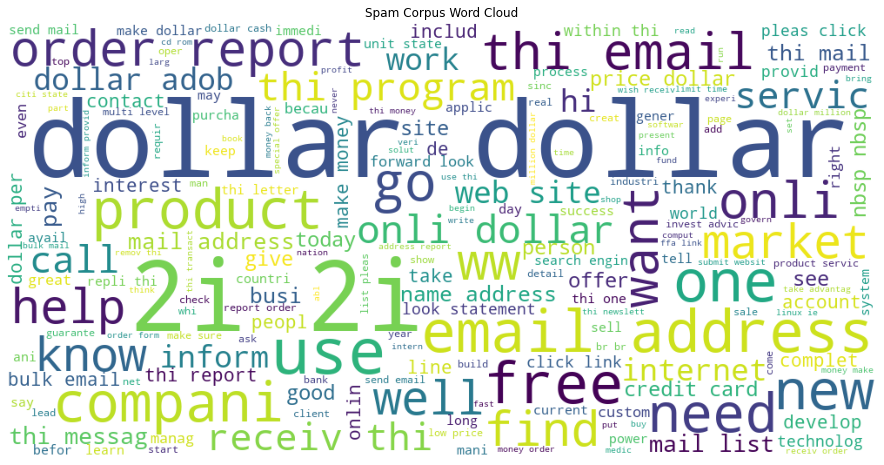

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='white')
# creating word cloud of spam emails
spam_wc = wc.generate(" ".join(spam_corpus))

plt.figure(figsize=(20,8))
plt.imshow(spam_wc)
plt.axis("off")
plt.title("Spam Corpus Word Cloud")
plt.show()

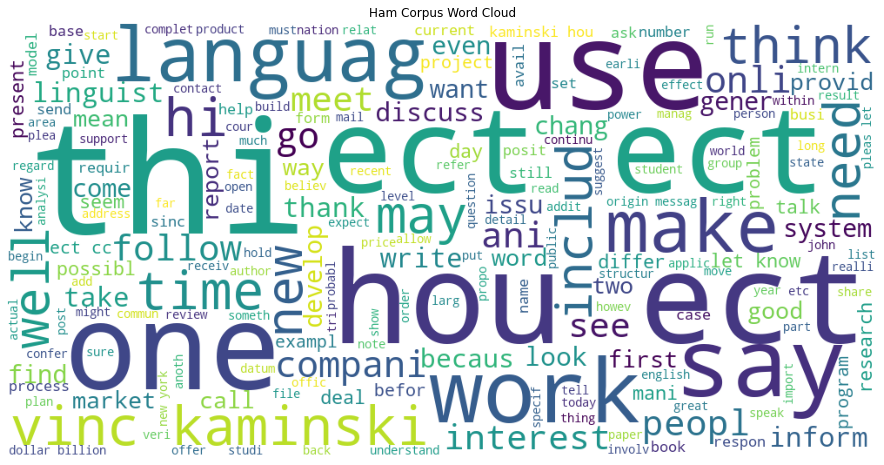

In [ ]:
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='white')
# creating word cloud of ham emails
ham_wc = wc.generate(" ".join(ham_corpus))

plt.figure(figsize=(20,8))
plt.imshow(ham_wc)
plt.axis("off")
plt.title("Ham Corpus Word Cloud")
plt.show()

In [ ]:
def test_model(test_mail,model):
  X_test=tvec.transform(test_mail)
  y_pred=model.predict(X_test)
  return y_pred

In [ ]:
def train_test_SVC_model(regularization,kernel_,df):
  X = df.Body
  Y = df.Label

  model = SVC(C=regularization,kernel=kernel_)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 225,stratify=Y)

  tvec = TfidfVectorizer()
  X_train = tvec.fit_transform(X_train)
  model.fit(X_train ,Y_train)
  X_test=tvec.transform(X_test)
  y_pred=model.predict(X_test)
  return accuracy_score(y_pred,Y_test)


In [ ]:
kernels=['linear', 'rbf']
regularization_c = np.linspace(1,15,10)

score_kernels=[]
for kernel_ in kernels:
  score_regul=[]
  for regularization in regularization_c:
    score_regul.append(train_test_SVC_model(regularization,kernel_,df))
  score_kernels.append(score_regul)

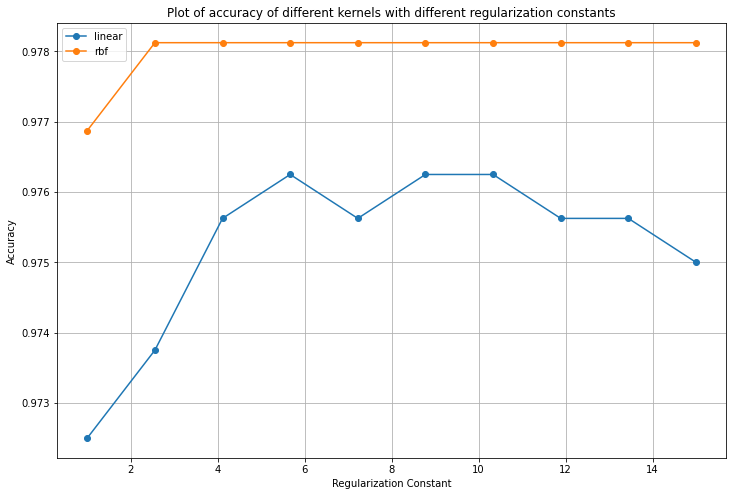

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,15,10),score_kernels[0],marker='o',label='linear')
plt.plot(np.linspace(1,15,10),score_kernels[1],marker='o',label='rbf')
# plt.plot(np.linspace(1,15,10),score_kernels[2],marker='o',label='poly')
# plt.plot(np.linspace(1,15,10),score_kernels[3],marker='o',label='sigmoid')
plt.legend()
plt.grid()
plt.xlabel('Regularization Constant')
plt.ylabel('Accuracy')
plt.title('Plot of accuracy of different kernels with different regularization constants')
plt.show()

In [ ]:
X = df.Body
Y = df.Label

idx_max_score=np.argmax(np.array(score_kernels))
if idx_max_score < len(np.linspace(1,15,10)):
  regularization=np.linspace(1,15,10)[idx_max_score]
  kernel_='linear'

else:
  regularization=np.linspace(1,15,10)[idx_max_score-len(np.linspace(1,15,10))]
  kernel_='rbf'

# print(regularization,kernel_)
model = SVC(C=regularization,kernel=kernel_)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 225,stratify=Y)

tvec = TfidfVectorizer()
X_train = tvec.fit_transform(X_train)
model.fit(X_train ,Y_train)
y_pred = test_model(X_test,model)
# return accuracy_score(y_pred,Y_test)

print("Model: SVM", "\n\tRegularization Constant: ",regularization,"\n\tKernel: ",kernel_)
print('Confusion Matrix:\n',confusion_matrix(y_pred,Y_test))
print("Accuracy\t:\t", accuracy_score(y_pred,Y_test))
print("Precision\t:\t", precision_score(y_pred,Y_test, average = 'weighted'))
print("Recall   \t:\t", recall_score(y_pred,Y_test, average = 'weighted'))

Model: SVM 
	Regularization Constant:  2.5555555555555554 
	Kernel:  rbf
Confusion Matrix:
 [[778  13]
 [ 22 787]]
Accuracy	:	 0.978125
Precision	:	 0.9781882812500001
Recall   	:	 0.978125


In [ ]:
def create_test_df_from_test_file():
  test_dataset = pd.DataFrame(columns = ['Mail','Body'])

  test_folder = './test'
  if os.path.exists(test_folder) == True :
    for root, subdirs, files in os.walk(test_folder):
      for filename in files:
        file_path = os.path.join(root, filename)

        with open(file_path, 'r') as f:
          f_content = f.read()
          test_dataset.loc[len(test_dataset.index)] = [filename, f_content]
  else:
    print("test folder doesn't exist")

  return test_dataset

In [ ]:
def predict_test_mails(test_df):
  test_df=preprocess_body(test_df)
  test_set=test_df.Body
  prediction=test_model(test_set,model=model)
  return prediction

In [ ]:
def model_testing():
  test_df = create_test_df_from_test_file()
  test_df=preprocess_body(test_df)
  pred=predict_test_mails(test_df)
  for i in range(len(test_df)):
    print(test_df['Mail'][i],"\t",pred[i])

In [ ]:
model_testing()

email0.txt 	 1
email11.txt 	 1
email7.txt 	 0
email9.txt 	 1
email6.txt 	 0
email12.txt 	 1
email2.txt 	 1
email10.txt 	 1
email4.txt 	 0
email3.txt 	 0
email1.txt 	 1
email13.txt 	 1
email8.txt 	 0
email5.txt 	 0
